In [1]:
# Imports
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
from scipy import ndimage
import os
import scipy.io

C:\Users\davide\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\davide\anaconda3\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [110]:
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' #main folder with data
bck_img_map = image.load_img(os.path.join(main_folder, 'rois' ,'MNI152_T1_1mm_Brain.nii')) #Background for plotting purposes
bck_img_map_smoothed = image.smooth_img(bck_img_map, fwhm=2) # MNI template smoothed (plotting purposes)
#List of subjects
subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']

#subjects = ['01','02','03', '04']

# .mat file with DCM results for Day-1 only. It contains all the EP values for anodal, cathodal and sham.
# I am interested only in anodal (indexes 0, 3, 6 ... 64)
dcm_data_day1_path = os.path.join(main_folder, 'wp2a_DCMfiles', 'Day1_all_EPvalues.mat') 
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)

# Posterior probability associated to each connection (per participant and for anodal, cathodal and sham, same as above).
# This is no longer used
pp_data_day1_path = os.path.join(main_folder, 'wp2a_DCMfiles','Day1_all_Pp.mat') 
pp_data_day1 = scipy.io.loadmat(pp_data_day1_path)

# Example: How to access DCM / PEB values for the anodal condition for participant 2
# Indexes: participant 1 -> 0, participant 2 -> 3, participant 3 -> 6 ... 64
# index = 3 # index corresponding to participant 2 (anodal)
# dcm_values = np.array(dcm_data_day1['ALLEP'][0][index].todense().reshape((4,4))).T
# pp_values = pp_data_day1['BMAs'][0][index]['Pp'][0][0][16:32].reshape([4,4]).T # PP values no longer used!

#Loading Regions of interest (Rois). These will be used to mask the electric field maps
# https://www.oxcns.org/papers/607%20Rolls%20Huang%20Lin%20Feng%20Joliot%202020%20AAL3.pdf 
AAl3_path = os.path.join(main_folder,'rois','AAL3v1_1mm.nii')
AAL3_atlas = image.load_img(AAl3_path)
# AAL3 index for M1 = 1
m1 = image.math_img("np.where(img == 1, 1, 0)", img=AAL3_atlas) 
# AAL3 index for TH = 121 - 149 (odd values only (left))
th = image.math_img("np.where(np.isin(img, np.arange(121, 150, 2)), 1, 0)", img=AAL3_atlas) 

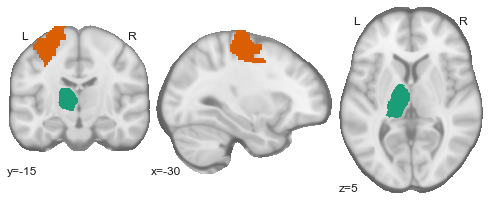

In [139]:
#AAL3 Left M1 and left thalamus ROIs
m1_th = image.math_img('img + np.where(img2 ==1, 2,0)', img = m1, img2 = th)
plotting.plot_stat_map(m1_th,
                       bg_img = bck_img_map,
                       cmap = 'Dark2_r',
                       colorbar = False,
                       cut_coords = [-30,-15,5],
                       draw_cross = False,
                       black_bg = False)

In [135]:
pos_dcm_res = 0 #Position of the DCM results for subject 1, day 1 (anodal) (0, 3, 6 ... 64) 

# Where I'll save m1 self connections and all th->m1
all_m1selfcon = []
all_thm1 = []
all_thselfcon = []
all_m1th = []

# Where I'll save emag values for m1 and th for each subject (means, medians, max values)
all_m1_emag_means = []
all_th_emag_means = []
all_m1_emag_medians = []
all_th_emag_medians = []
all_m1_emag_max = []
all_th_emag_max = []

# I am also going to store all the Emag maps in a multi-dimentional array, for plotting purposes
all_emag_maps = []

for sbj in subjects:
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj
    print('Analysing subject: ' + sbj + '. Path: ' + path)
    
    #Loading ROAST Electric field magnitude simulation (V/m)
    emag_map = image.load_img(glob.glob(path+ '/wsub-*_T1_*_emag.nii'))
    scan_shape = emag_map.get_fdata().shape[0:3]
    emag_data = emag_map.get_fdata().reshape(scan_shape) # needed to drop 4th dimention in the array (that shouldn't be there)
    emag_map = new_img_like(emag_map,emag_data) 
    
    # Loading masks containing gray matter, white matter and csf
    grey_matter = image.load_img(glob.glob(path+ '/wc1sub*.nii')).get_fdata().reshape(scan_shape) 
    white_matter = image.load_img(glob.glob(path+ '/wc2sub*.nii')).get_fdata().reshape(scan_shape)
    csf = image.load_img(glob.glob(path+ '/wc3sub*.nii')).get_fdata().reshape(scan_shape)
   
    # I am still working on this bit -----
    # These maps are probabilistic maps. Some voxels overlap. To define two mutually
    # exclusive maps I first threshold the white matter mask and keep only values values > 0.5
    white_matter_th = np.where(white_matter > 0.5, 1,0)
    
    # Applying binary erosion of 1 voxel
    white_matter_bin_er = ndimage.binary_erosion(white_matter_th).astype(white_matter_th.dtype)
    wm_eroded = new_img_like(emag_map, white_matter_bin_er) 

    
    # Map containing conductivity values for GM (default 0.276 S/m) and WM (default 0.126 S/m)
    #grey_matter_c = np.where(grey_matter > 0,0.276,0)
    #white_matter_c = np.where(white_matter > 0,0.126,0)
    
    # Calculating current density
    
    #current_density = 
    # ----------------
    
    
    # Applying fwhm smoothing to the electric field magnitude map. Kernel 4x4x4
    emag_map_smoothed = image.smooth_img(emag_map, fwhm=4) # Emag map
    
    # Resampling MNI anatomical file to emag map (so that they have the same shape)
    mni_resampled = image.resample_to_img(bck_img_map, emag_map, interpolation = 'nearest')    
    
    #Emag map masked (to exclude the skull, and keep only values of voxels in the brain)
    emag_map_masked = image.math_img("np.where(img2 != 0, img, 0)", img=emag_map_smoothed, img2 = mni_resampled)
    
    # Resampling ROIs to the dimention of the emag map
    m1_resampled = image.resample_to_img(m1, emag_map_masked, interpolation = 'nearest')
    th_resampled = image.resample_to_img(th, emag_map_masked, interpolation = 'nearest')
    
    #Loading DCM results and Posterior probabilities for the subject
    #Transposing is needed because the PEB lists values column by row and not row by column...

    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4))).T
    this_pp = pp_data_day1['BMAs'][0][pos_dcm_res]['Pp'][0][0][16:32].reshape([4,4]).T
    
    print('DCM matrix')
    # If you want to see the connectivity matrix for each subject, but thresholded using a posterior probability > 75%
    print(np.where(this_pp>0.75,this_dcm,0)) 
    print('Posterior probability')
    print(this_pp)
    
    # DCM connectivities I'm interested in 
    m1m1 = this_dcm[0][0]
    thm1 = this_dcm[0][1]
    thth = this_dcm[1][1]
    m1th = this_dcm[1][0]
    
    # Saving the DCM values into separate lists
    all_m1selfcon.append(m1m1)
    all_thm1.append(thm1)
    all_m1th.append(m1th)
    all_thselfcon.append(thth) 
    
    #print('M1<->M1 connectivity: ' + str(m1m1))
    #print('Th<->Th connectivity: ' + str(thth))
    #print('M1<->th connectivity: ' + str(m1th))
    #print('Th<->M1 connectivity: ' + str(thm1))
    
    # Masking emag maps with M1 and Th rois
    emag_masked_m1 = image.math_img("img * img2", img=emag_map_masked, img2 = m1_resampled) #Applying m1 mask
    emag_masked_th = image.math_img("img * img2", img=emag_map_masked, img2 = th_resampled) #Applying th mask
    
    # Assigning nans to zeros to exclude non M1/Th voxels from the calculation of the mean
    emag_masked_m1_nans = np.where(m1_resampled.get_fdata() == 0, np.nan, emag_masked_m1.get_fdata())
    emag_masked_th_nans = np.where(th_resampled.get_fdata() == 0, np.nan, emag_masked_th.get_fdata())

    # Calculating means, medians and max values
    m1_emag_mean = np.nanmean(emag_masked_m1_nans)
    th_emag_mean = np.nanmean(emag_masked_th_nans)
    m1_emag_median = np.nanmedian(emag_masked_m1_nans)
    th_emag_median = np.nanmedian(emag_masked_th_nans)
    m1_emag_max = np.nanmax(emag_masked_m1_nans)
    th_emag_max = np.nanmax(emag_masked_th_nans)
       
    # Saving means, medians and max values into lists
    all_m1_emag_means.append(m1_emag_mean)
    all_th_emag_means.append(th_emag_mean)   
    all_m1_emag_medians.append(m1_emag_median)
    all_th_emag_medians.append(th_emag_median)  
    all_m1_emag_max.append(m1_emag_max)
    all_th_emag_max.append(th_emag_max)   
    
    print('Mean Electric field in M1: ' + str(round(m1_emag_mean,3)))
    print('Mean Electric field in Th: ' + str(round(th_emag_mean,3)))
    print('Median Electric field in M1: ' + str(round(m1_emag_median,3)))
    print('Median Electric field in Th: ' + str(round(th_emag_median,3)))
    print('Max Electric field in M1: ' + str(round(m1_emag_max,3)))
    print('Max Electric field in Th: ' + str(round(th_emag_max,3)))
    print('\n')
    
        
    all_emag_maps.append(emag_map_masked)
    #Moving to the next subject
    pos_dcm_res += 3 
    
    
    
# Saving results into two dictionaries
emag_all_results = {'Medians M1': all_m1_emag_medians,'Medians Th': all_th_emag_medians,
                    'Max values M1': all_m1_emag_max,'Max values Th': all_th_emag_max}

dcm_all_results = {'M1M1': all_m1selfcon, 'M1Th': all_m1th, 'ThTh': all_thselfcon, 'ThM1': all_thm1}

Analysing subject: 01. Path: D:\roast-chapter3\wp2a_copy\sub-01
DCM matrix
[[ 0.         -0.14524401  0.          0.27560144]
 [-0.07975794  0.          0.          0.16814571]
 [ 0.         -0.1373137   0.          0.        ]
 [ 0.         -0.15147347  0.          0.        ]]
Posterior probability
[[0.5284718  1.         0.55396588 1.        ]
 [1.         0.         0.         1.        ]
 [0.         1.         0.60237555 0.52148489]
 [0.         1.         0.         0.54511604]]
Mean Electric field in M1: 0.321
Mean Electric field in Th: 0.083
Median Electric field in M1: 0.149
Median Electric field in Th: 0.084
Max Electric field in M1: 3.615
Max Electric field in Th: 0.128


Analysing subject: 02. Path: D:\roast-chapter3\wp2a_copy\sub-02
DCM matrix
[[-0.36221701  0.          0.          0.        ]
 [ 0.          0.         -0.13382803  0.18316923]
 [ 0.40141591  0.          0.          0.        ]
 [ 0.          0.         -0.16035369  0.        ]]
Posterior probability
[[1. 

Mean Electric field in M1: 0.296
Mean Electric field in Th: 0.084
Median Electric field in M1: 0.128
Median Electric field in Th: 0.084
Max Electric field in M1: 3.195
Max Electric field in Th: 0.126


Analysing subject: 15. Path: D:\roast-chapter3\wp2a_copy\sub-15
DCM matrix
[[ 0.         -0.45486953  0.          0.6167848 ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.16703947  0.          0.41729962]
 [ 0.10600421 -0.22664464  0.         -0.18780245]]
Posterior probability
[[0.61061378 1.         0.         1.        ]
 [0.         0.58331606 0.         0.        ]
 [0.49436993 1.         0.58059279 1.        ]
 [1.         1.         0.         0.77422604]]
Mean Electric field in M1: 0.321
Mean Electric field in Th: 0.084
Median Electric field in M1: 0.124
Median Electric field in Th: 0.085
Max Electric field in M1: 3.302
Max Electric field in Th: 0.125


Analysing subject: 16. Path: D:\roast-chapter3\wp2a_copy\sub-16
DCM matrix
[[ 0.          0.          0. 

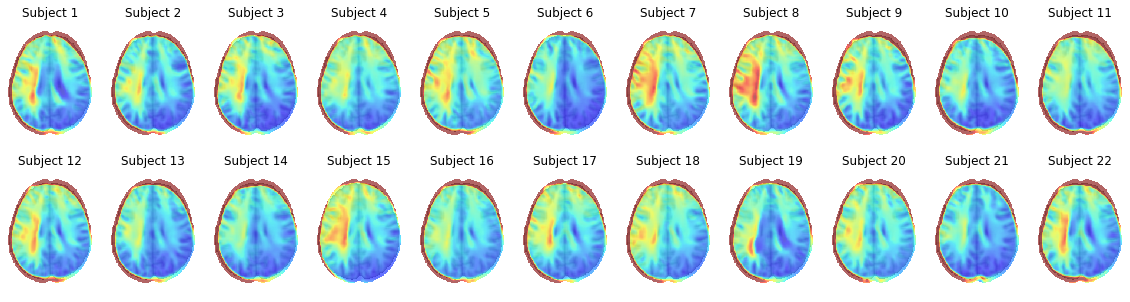

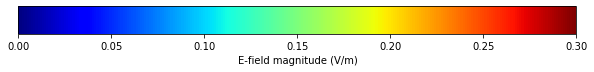

In [4]:
# create a figure with multiple axes to plot each Emag map
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(20,5))

vmin, vmax = 0, 0.3 # Color map min and max
# axes is a 2 dimensional numpy array
subject = 0
for ax in axes.flatten():
    display = plotting.plot_roi(all_emag_maps[subject],
              #bg_img = bck_img_map_smoothed,
              display_mode = 'z',
              annotate = False,
              dim = 0.5,
              cmap = 'jet',
              cut_coords = [28],
              threshold = 0.001,
              vmin = vmin,
              vmax = vmax,
              alpha = 0.60,
              draw_cross = False,
              black_bg = False,
              axes = ax)
    ax.title.set_text('Subject ' + str(subject + 1))
    subject += 1
    
# Colorbar for the above brain plots
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='E-field magnitude (V/m)')    
    

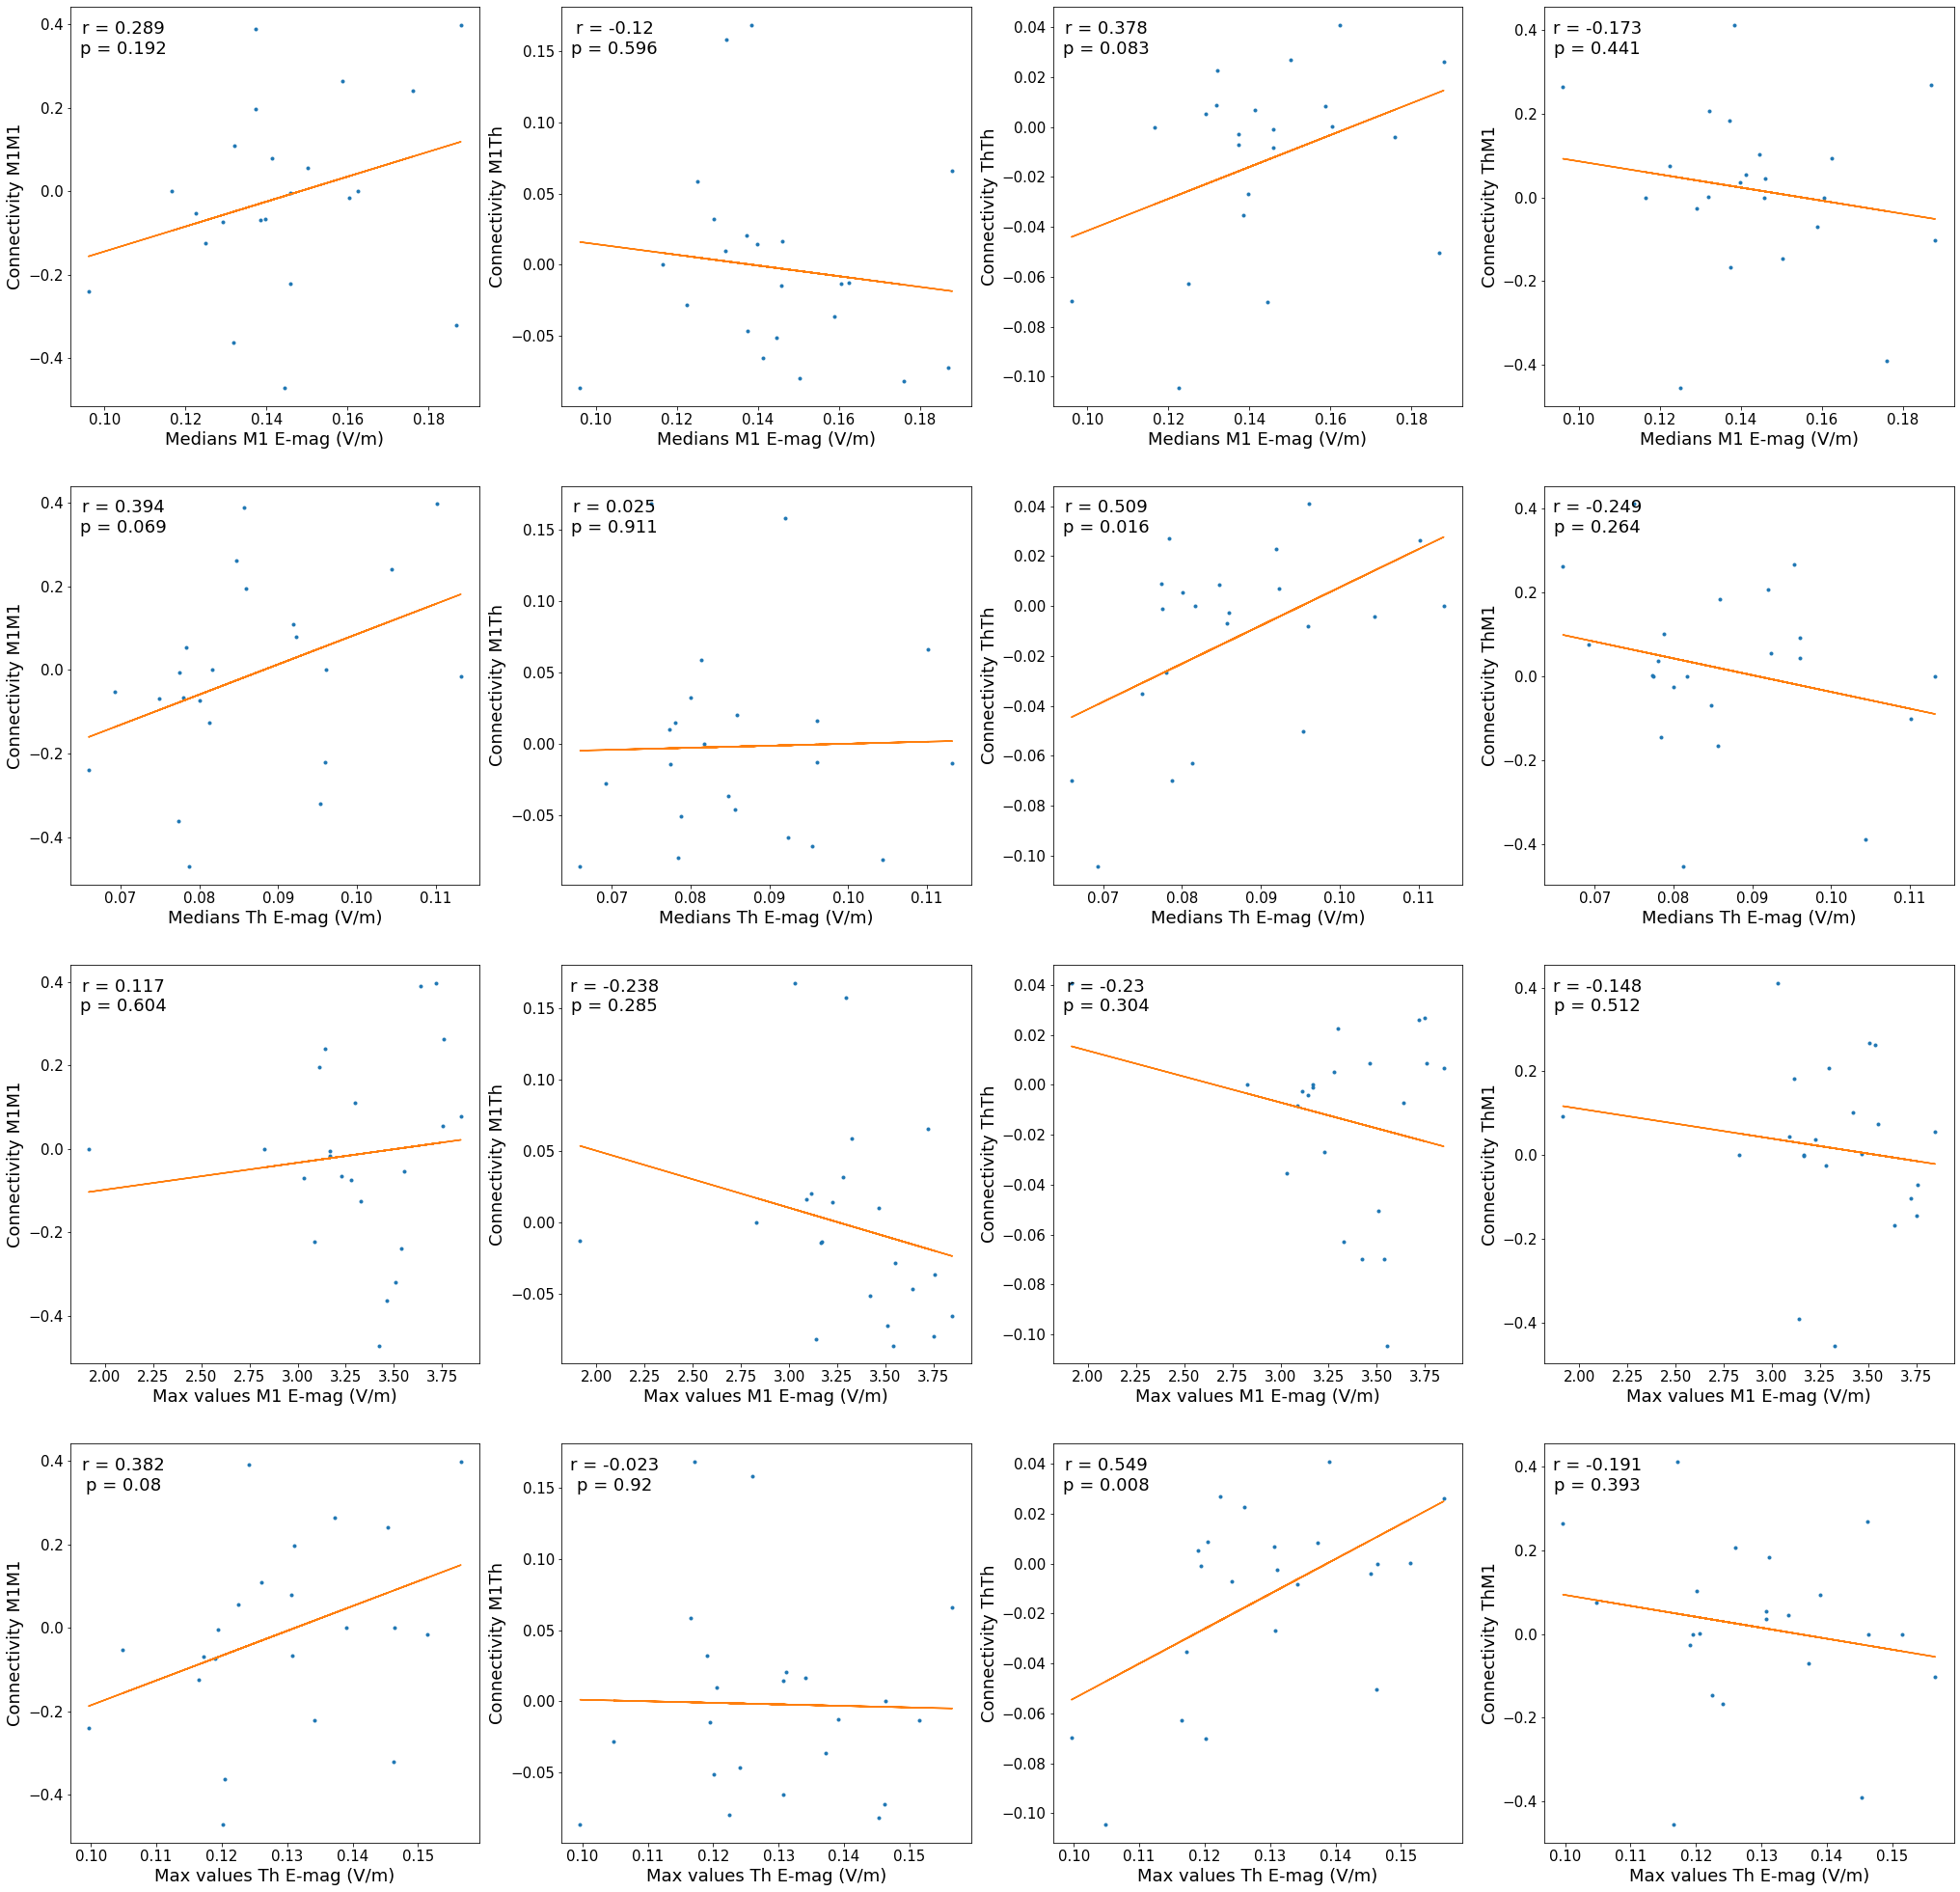

In [5]:
# Correlations between connectivity measures and Electric field magnitude medians and max values
from numpy.polynomial.polynomial import polyfit

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(35,35))

idx = 0
for emag_measure in emag_all_results:
    for dcm_con in dcm_all_results:
        x = np.transpose(emag_all_results[emag_measure])
        y = np.transpose(dcm_all_results[dcm_con])
        r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r

        # Correlation Plot
        row = int(idx/4);
        col = int(idx%4); 
        b, m = polyfit(x, y, 1)
        
        axes[row][col].plot(x, y, '.')
        axes[row][col].plot(x, b + m * x, '-')
        #axes[row][col].title.set_text('Correlating ' + emag_measure + ' with ' + dcm_con)
        axes[row][col].set_xlabel(emag_measure + ' E-mag (V/m)', fontsize = 18)
        axes[row][col].set_ylabel('Connectivity ' + dcm_con, fontsize = 18)
        axes[row][col].tick_params(axis='both', which='major', labelsize=15)
        axes[row][col].text(0.13, 0.92, 'r = ' + str(round(r,3)) + '\np = ' + str(round(p,3)), horizontalalignment='center',
                            verticalalignment='center', transform=axes[row][col].transAxes, fontsize = 18)
        idx += 1
        

C:\Users\davide\anaconda3\lib\site-packages\seaborn\utils.py:178: FutureWarning: This function is deprecated and will be removed in a future version
  warnings.warn(msg, FutureWarning)


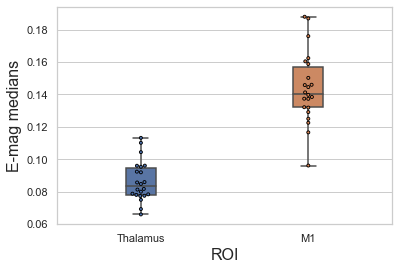

In [6]:
# Plotting electric field medians for M1 and Th
import seaborn as sns, matplotlib.pyplot as plt, operator as op

emag_results_toplot = {'M1': all_m1_emag_medians,'Thalamus': all_th_emag_medians}

sorted_keys, sorted_vals = zip(*sorted(emag_results_toplot.items(), key=op.itemgetter(1)))

sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="ROI", ylabel="E-mag medians", fontsize=16)

sns.boxplot(data=sorted_vals, width=.18)
sns.swarmplot(data=sorted_vals, size=3, edgecolor="black", linewidth=.9)

# category labels
plt.xticks(plt.xticks()[0], sorted_keys)

plt.show()

Analysing subject: 01. Path: D:\roast-chapter3\wp2a_copy\sub-01
Analysing subject: 02. Path: D:\roast-chapter3\wp2a_copy\sub-02
Analysing subject: 03. Path: D:\roast-chapter3\wp2a_copy\sub-03
Analysing subject: 04. Path: D:\roast-chapter3\wp2a_copy\sub-04
Analysing subject: 06. Path: D:\roast-chapter3\wp2a_copy\sub-06
Analysing subject: 07. Path: D:\roast-chapter3\wp2a_copy\sub-07
Analysing subject: 08. Path: D:\roast-chapter3\wp2a_copy\sub-08
Analysing subject: 09. Path: D:\roast-chapter3\wp2a_copy\sub-09
Analysing subject: 10. Path: D:\roast-chapter3\wp2a_copy\sub-10
Analysing subject: 11. Path: D:\roast-chapter3\wp2a_copy\sub-11
Analysing subject: 12. Path: D:\roast-chapter3\wp2a_copy\sub-12
Analysing subject: 13. Path: D:\roast-chapter3\wp2a_copy\sub-13
Analysing subject: 14. Path: D:\roast-chapter3\wp2a_copy\sub-14
Analysing subject: 15. Path: D:\roast-chapter3\wp2a_copy\sub-15
Analysing subject: 16. Path: D:\roast-chapter3\wp2a_copy\sub-16
Analysing subject: 17. Path: D:\roast-ch

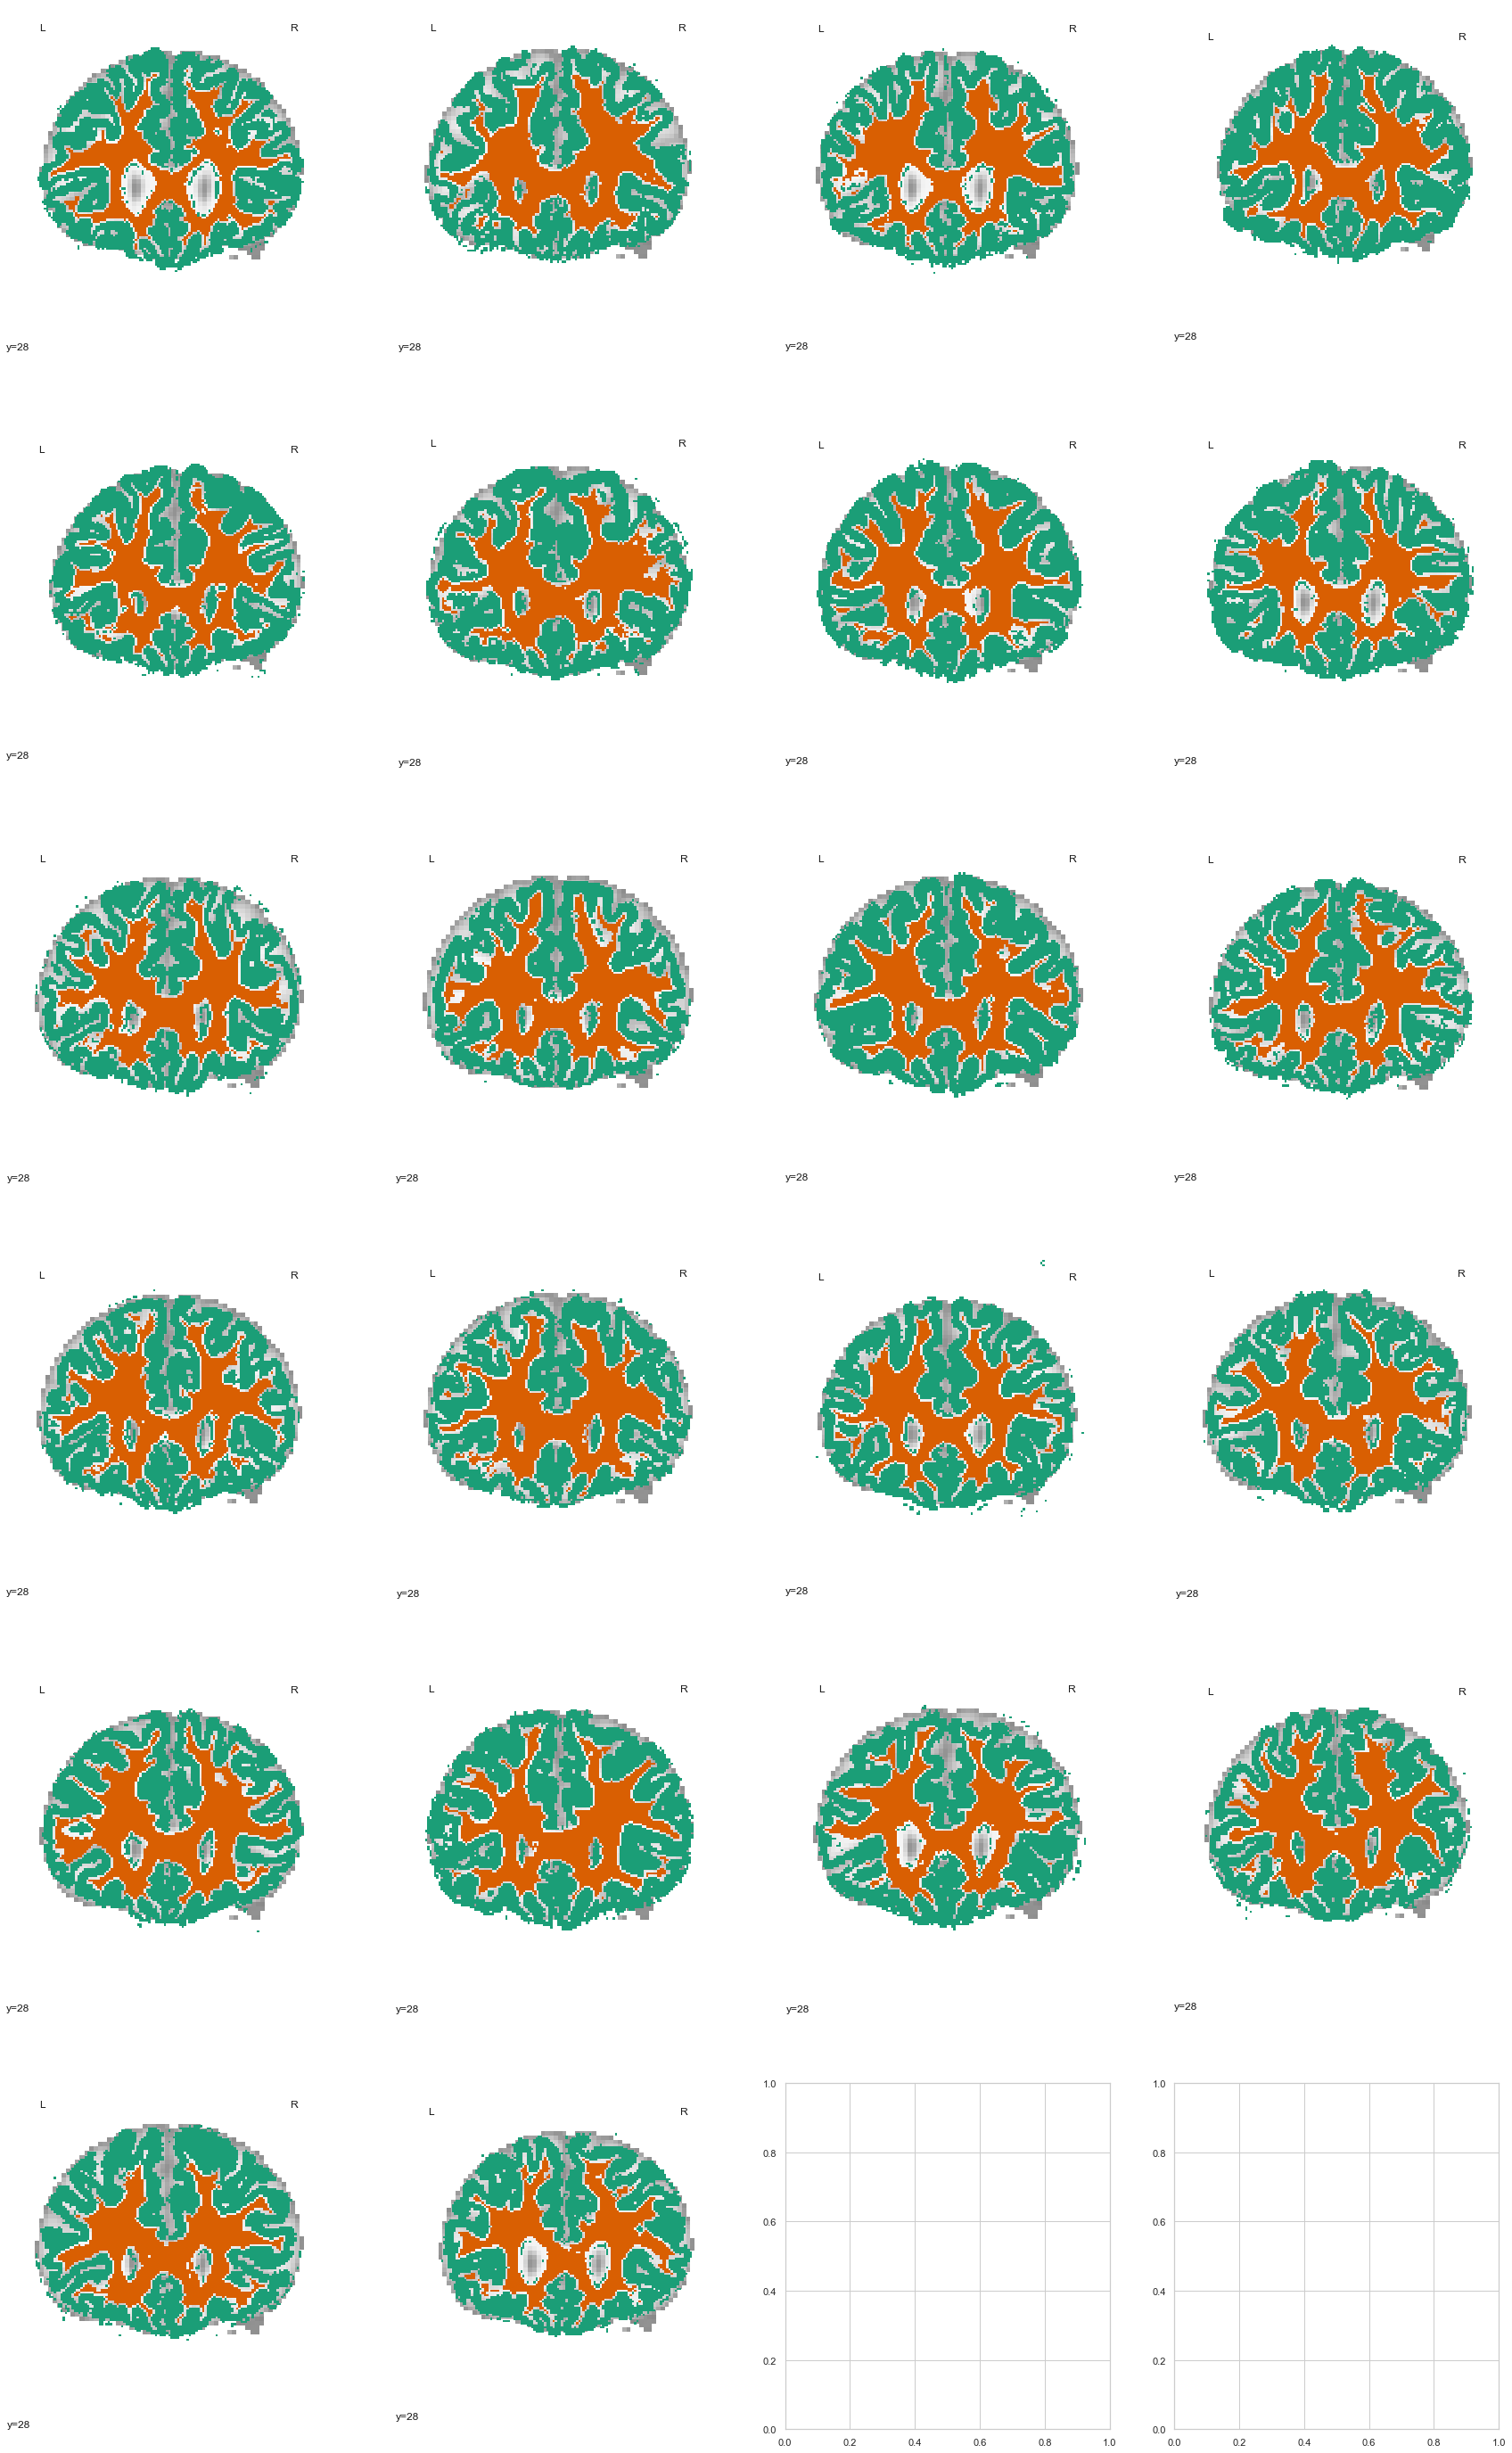

In [185]:
# White matter stuff (remove)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30,50))

idx = 0

for sbj in subjects:
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj
    print('Analysing subject: ' + sbj + '. Path: ' + path)
    
    # Loading masks containing gray matter, white matter and csf
    emag_map = image.load_img(glob.glob(path+ '/wsub-*_T1_*_emag.nii'))
    grey_matter = image.load_img(glob.glob(path+ '/wc1sub*.nii')).get_fdata().reshape(scan_shape) 
    white_matter = image.load_img(glob.glob(path+ '/wc2sub*.nii')).get_fdata().reshape(scan_shape)
    csf = image.load_img(glob.glob(path+ '/wc3sub*.nii')).get_fdata().reshape(scan_shape)
    
    white_matter_map = new_img_like(emag_map, white_matter)

    th_wm = 0.5
    th_gm = 0.25 #threshold for the grey matter
    
    wm_thresholded = np.where(white_matter > th_wm, 1,0)
    wm_eroded = ndimage.binary_erosion(wm_thresholded).astype(wm_thresholded.dtype)
    
    gm_binary = np.where((grey_matter > th_gm) & (grey_matter > white_matter), 2, 0)
    wm_binary = np.where((wm_eroded == 1) & (grey_matter < white_matter), 1, 0)
    wm_gm = new_img_like(emag_map, wm_binary + gm_binary)
    
    
    
    row = int(idx/4);
    col = int(idx%4);
    display = plotting.plot_stat_map(wm_gm, cmap='Dark2_r', colorbar = False,
                                     display_mode = 'y',
                                     cut_coords = [28],                                     
                                     axes = axes[row][col])
    idx += 1
        
        
        
        
        
#
#plotting.plot_stat_map(white_matter_map, cmap='Oranges', display_mode='z', cut_coords = [30])
#plotting.plot_stat_map(wm_thresholded_img, cmap='Dark2_r', display_mode='z', colorbar = False, cut_coords = [30])
#plotting.plot_stat_map(wm_eroded, cmap='Dark2_r', display_mode='z', colorbar = False, cut_coords = [30])